<a href="https://colab.research.google.com/github/sfluegel05/KINeuro2022/blob/main/KINeuro_3_Data_Generation_max_23_03_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip --quiet install mne
!pip --quiet install braindecode
!pip --quiet install opencv-python
!pip --quiet install pooch
!pip --quiet install nibabel
!pip --quiet install cupy-cuda115
!pip --quiet install joblib
!pip --quiet install surfer

You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\max ksoll\pycharmprojects\testproject\venv\scripts\python.

In [ ]:
import os
import numpy as np
from numpy import array as create_array
from numpy import argpartition, argmax, sqrt, pi, exp, sum, arange, sin, concatenate, zeros
from numpy.linalg import norm
from numpy.random import choice
import matplotlib.pyplot as plt
import math
from cv2 import flip, resize

import mne

import torch

from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)

rng = np.random.RandomState(10)  # Gives reproducible results

{'ch_pos': OrderedDict([('Fp1', array([-0.02821418,  0.080432  , -0.0066997 ])), ('Fpz', array([ 0.00010764,  0.08458207, -0.00164186])), ('Fp2', array([ 0.02863169,  0.08137015, -0.00678597])), ('AF9', array([-0.04693703,  0.06142564, -0.04570271])), ('AF7', array([-0.05256219,  0.06572438, -0.01015019])), ('AF5', array([-0.04354395,  0.06983621,  0.00572973])), ('AF3', array([-0.0323011 ,  0.07364603,  0.02034544])), ('AF1', array([-0.01770456,  0.07658566,  0.0313918 ])), ('AFz', array([0.00022169, 0.07741656, 0.03394612])), ('AF2', array([0.01899716, 0.07696694, 0.0314033 ])), ('AF4', array([0.03422916, 0.07449792, 0.02104416])), ('AF6', array([0.04464964, 0.07074254, 0.00578341])), ('AF8', array([ 0.05342826,  0.06676393, -0.01030834])), ('AF10', array([ 0.04834061,  0.06121727, -0.04601134])), ('F9', array([-0.06719055,  0.03992247, -0.04787748])), ('F7', array([-0.06734486,  0.04071033, -0.01094572])), ('F5', array([-0.06178852,  0.04604038,  0.01621827])), ('F3', array([-0.0481

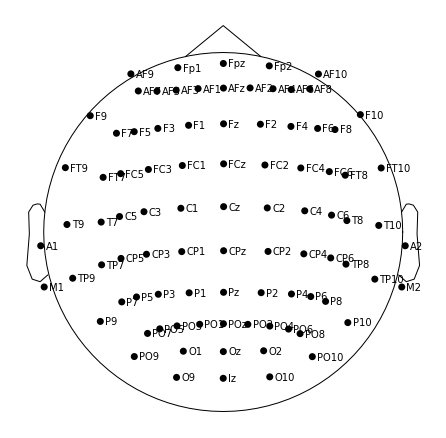

Creating RawArray with float64 data, n_channels=31, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Using matplotlib as 2D backend.


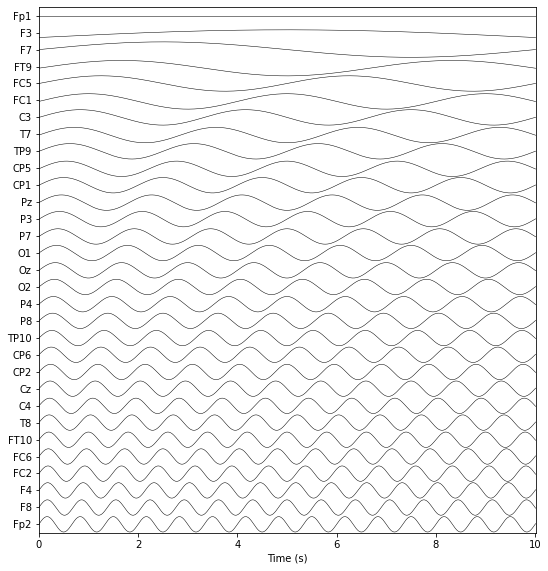

<RawArray | 31 x 10000 (100.0 s), ~2.4 MB, data loaded>

In [ ]:
# use standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
print(montage.get_positions())
montage.plot()

channel_names = [
            "Fp1", "F3", "F7", "FT9", "FC5", "FC1", "C3", "T7", "TP9", "CP5",
            "CP1", "Pz", "P3", "P7", "O1", "Oz", "O2", "P4", "P8", "TP10", 
            "CP6", "CP2", "Cz", "C4", "T8", "FT10", "FC6", "FC2", "F4", "F8", 
            "Fp2"
            ]
channel_types = ["eeg" for name in channel_names]
# parameter value from paper
sampling_frequency = 100

info = mne.create_info(ch_names=channel_names, sfreq=sampling_frequency, 
                       ch_types=channel_types)

# dummy data, to be replaced with real data
t = np.arange(0, 100, 1/sampling_frequency)
freqs = [i*0.1 for i in range(len(channel_types))]
data = np.array([np.sin(freq*t*np.pi)  for freq in freqs])

raw_array = mne.io.RawArray(data, info)

raw_array.plot(show_scrollbars=False, show_scalebars=False, scalings=1.1, 
               n_channels=len(channel_names))

raw_array.set_montage(montage=montage)
raw_array.pick_channels(ch_names=channel_names)



Fetch fsaverage data ... Done.
Create BEM model ... Done.
Compute solution of BEM model ... Done.

Plot BEM model
--------------
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


C:\Users\Max Ksoll\PycharmProjects\TestProject\venv\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


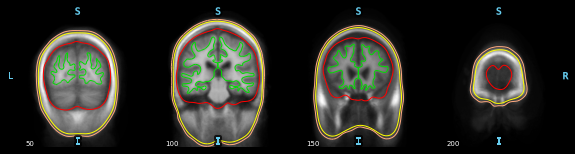

In [ ]:
# fsaverage: standard brain model from Free Surfer
print("Fetch fsaverage data ... ", end="")
fs_dir = mne.datasets.fetch_fsaverage(verbose=False)     
subjects_dir = os.path.dirname(fs_dir)
print("Done.")

# Specify the subject (tells MNE something about the subjects head)
fsaverage_subject = 'fsaverage'
fsaverage_transformation = 'fsaverage'  # MNE has an inbuild fsaverage Transformation

# BEM (Boundary element method)
print("Create BEM model ... ", end="")
# ico=4 means 5120 dipoles (5120 dipoles is the paper-value)
# conductivity: open questions: which value stands for which layer?
# why does the tutorial use a 4-layer model, not a 3-layer one?
# why is the paper using 0.06 instead of 0.006? is it a typo?
# paper: 3-layer model, 0.3 S/m^2 for brain and scalp tissue, 0.06 S/m^2
surfaces = mne.make_bem_model(subject=fsaverage_subject, ico=4, conductivity=[0.3, 0.06, 0.3], 
                              subjects_dir=subjects_dir, verbose=False)
# alternative model: conductivity 0.332 for brain and scalp, 0.0113 for skull
alt_surfaces = mne.make_bem_model(subject=fsaverage_subject, conductivity=[0.332, 0.0113, 0.332], 
                              subjects_dir=subjects_dir, verbose=False)
print("Done.")
print("Compute solution of BEM model ... ", end="")
# make_bem_solution "computes the geometry information for BEM" 
# (https://mne.tools/stable/overview/implementation.html#computing-the-bem-geometry-data)
bem_model = mne.make_bem_solution(surfs=surfaces, verbose=False)
alt_bem_model = mne.make_bem_solution(surfs=alt_surfaces, verbose=False)

print("Done.")
plot_bem_kwargs = dict(
    subject=fsaverage_subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])

print("\nPlot BEM model\n"
      "--------------")
mne.viz.plot_bem(**plot_bem_kwargs)
pass


Create Source space ...
<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562>, <surface (rh), n_vertices=163842, n_used=2562>] MRI (surface RAS) coords, subject 'fsaverage', ~29.5 MB>
Done

Plot BEM model with source_spaces
--------------
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


C:\Users\Max Ksoll\PycharmProjects\TestProject\venv\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Solve the forward problem ...
[[  7.29682985  69.26273012 -43.25328319 ... -33.27836154  64.24662086
   10.4547758 ]
 [-35.3795097  165.91149351 -39.69782827 ... -32.25905909  37.57511588
   24.59496274]
 [-32.73673638  58.20437959 -65.19637627 ... -42.2372262   32.13465346
    8.35274335]
 ...
 [ 54.90911891  52.11174833  -9.77260766 ...   1.47055116  77.53170609
   49.85106726]
 [ 37.72880591  25.58677477 -23.40915208 ...  78.58490634 178.70059461
   21.26790547]
 [ 28.83230566  51.93669257 -30.12875592 ... -12.6890671  103.29919508
   11.23589788]]
Done.


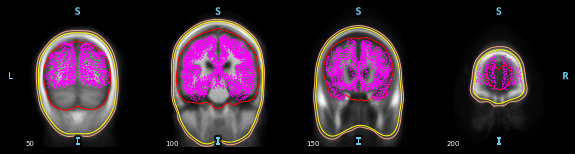

In [ ]:
print("Create Source space ...")
# spacing: paper says "icosahedral" (and "octahedral with a higher resolution"
# for the alternative model)
# ico4 has 2562 sources per hemishpere, oct6 has 4098 per hemisphere
# see https://mne.tools/stable/overview/cookbook.html#setting-up-source-space
# paper says 5124 dipoles (alternative model: 8196)
source_spaces = mne.setup_source_space(
    fsaverage_subject, spacing='ico4', add_dist='patch', subjects_dir=subjects_dir, verbose=False
    )

print(source_spaces)
print("Done")

print("\nPlot BEM model with source_spaces\n"
      "--------------")
mne.viz.plot_bem(src=source_spaces, **plot_bem_kwargs)

# Solve the problem --> Leadfield
print("Solve the forward problem ...")
fwd = mne.make_forward_solution(raw_array.info, trans=fsaverage_transformation, 
                                src=source_spaces, bem=bem_model, eeg=True, 
                                mindist=5.0, n_jobs=1, verbose=False)

print(fwd["sol"]["data"])


# We transform the solution such that it is orthogonal to the head / brain 
fwd_fixed = mne.convert_forward_solution(
    fwd, surf_ori=True, force_fixed=True, use_cps=True, verbose=False
    )

print("Done.")

Create Alternative Source space ...
<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~30.0 MB>
Done

Plot BEM model with alt_source_spaces
--------------
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\Max Ksoll\mne_data\MNE-fsaverage-data\fsaverage\bem\outer_skin.surf


C:\Users\Max Ksoll\PycharmProjects\TestProject\venv\lib\site-packages\mne\viz\utils.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


[[  2.06486919  64.46108216 -33.33256938 ... -27.08444127  59.48340639
    6.73345595]
 [-40.92554957 122.31784737 -12.30993632 ... -30.00131791  37.58801039
   18.84325152]
 [-37.91219052  51.56410835 -47.72486274 ... -36.84343147  29.85495707
    5.87955062]
 ...
 [ 46.20977064  46.12647676  -1.83798648 ...  10.02626104  70.20682088
   35.07735102]
 [ 35.17497722  23.71393984 -17.10320881 ...  75.15956798 112.92060722
    6.17705348]
 [ 25.39113749  48.70693044 -23.04687362 ...  -2.24659708  88.23357406
    5.67101296]]
Done.


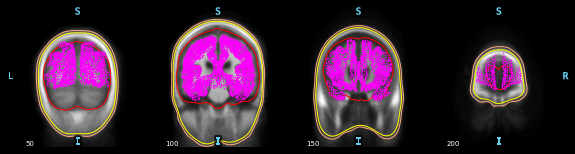

In [ ]:
# same as above, but with alternative model (for validation data)
print("Create Alternative Source space ...")
# use oct6 as spacing -> gives 8196 dipoles
# see https://mne.tools/stable/overview/cookbook.html#setting-up-source-space
alt_source_spaces = mne.setup_source_space(
    fsaverage_subject, spacing='oct6', add_dist='patch', subjects_dir=subjects_dir, verbose=False
    )

print(alt_source_spaces)
print("Done")

print("\nPlot BEM model with alt_source_spaces\n"
      "--------------")
mne.viz.plot_bem(src=alt_source_spaces, **plot_bem_kwargs)

# Solve the problem --> Leadfieldprint("Solve the forward problem ...")
alt_fwd = mne.make_forward_solution(raw_array.info, trans=fsaverage_transformation, 
                                src=alt_source_spaces, bem=alt_bem_model, eeg=True, 
                                mindist=5.0, n_jobs=1, verbose=False)

print(alt_fwd["sol"]["data"])


# We transform the solution such that it is orthogonal to the head / brain 
alt_fwd_fixed = mne.convert_forward_solution(
    alt_fwd, surf_ori=True, force_fixed=True, use_cps=True, verbose=False
    )

print("Done.")

In [ ]:
from functools import wraps
from time import process_time


def measure(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(process_time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(process_time() * 1000)) - start
            print(
                f"Total execution time {func.__name__}: {end_ if end_ > 0 else 0} ms"
            )

    return _time_it

In [ ]:
def eucl_dist(a, b):
  return norm(a-b)

def gaussian_attenuation(mean, sigma, x):
  return 1./(sigma * sqrt(2. * pi)) * exp(-(x - mean)**2 / (2. * sigma**2))

def has_same_position(a, b):
  return np.array_equal(a,b)

def find_signal_peak(raw_data, verbose=False):
    time_point_idx = argmax(sum(raw_data, axis=0), axis=0)
    return (raw_data[:,time_point_idx], time_point_idx)

In [ ]:
# @measure
def grow_region(center, order, candidates, neighbours_per_neighbourhood=7, verbose=False):
  max_radius = 0.
  res = [center]
  outer_layer = [center]

  for _ in range(order):
    new_outer_layer = []
    for point in outer_layer:
#       distances = create_array(list(map(eucl_dist, candidates, [point for _ in range(len(candidates))])))
      distances = create_array(list(map(norm, candidates-point)))
      smallest_neighbours_idx = argpartition(distances, neighbours_per_neighbourhood)[:neighbours_per_neighbourhood]
      neighbours_of_point = [(candidates[idx], distances[idx]) for idx in smallest_neighbours_idx]

      # only add candidates to res that are not already present in res
      # hier ist potenzial für matrizen
      for neigh in neighbours_of_point:
        add_neigh = True
            
        res_idx = 0
        while add_neigh and res_idx < len(res):
            add_neigh &= not has_same_position(res[res_idx], neigh[0])
            if(not add_neigh):
                break
            res_idx += 1
            
        if add_neigh:
          res.append(neigh[0])
          new_outer_layer.append(neigh[0])
          # update max_radius
          dist = eucl_dist(neigh[0], center) 
          if dist > max_radius:
            max_radius = dist
        
    outer_layer = new_outer_layer
  return res, max_radius

In [ ]:
# @measure
def generate_sources(source_spaces, n_centers, neighbourhoods_min, neighbourhoods_max, verbose=False):
  dipole_moment_min = 5e-9 # A
  dipole_moment_max = 10e-9 # A
  epoch_length = 1 # s
  sampling_frequency = 100 # Hz
  temporal_extension = 0.1 # s
  sinusoidal_frequency = 5 # Hz

  n_times = epoch_length*sampling_frequency

  # extract dipole positions from source_spaces
  pos_left = create_array(mne.vertex_to_mni(source_spaces[0]['vertno'], 0, fsaverage_subject, verbose=False))
  pos_right = create_array(mne.vertex_to_mni(source_spaces[1]['vertno'], 1, fsaverage_subject, verbose=False))
  pos = concatenate([pos_left, pos_right], axis=0)

  # pick centers
  centers = choice(arange(pos.shape[0]), n_centers)
  # generate time course for each center
  time_courses = []
  dipole_moments = []

  for _ in range(n_centers):
    # select window of length temporal_extension in the epoch
    window = zeros(n_times)
    start = rng.randint(0, (epoch_length - temporal_extension) * sampling_frequency)
    stop = start + int(temporal_extension * sampling_frequency)
    window[start:stop] = 1.
    # select dipole moment
    dipole_moment = rng.random() * (dipole_moment_max - dipole_moment_min) + dipole_moment_min
    # create sine function
    course = dipole_moment * sin(2. * pi * sinusoidal_frequency 
                                    * arange(start=0, stop=epoch_length, step=1/sampling_frequency))
    course *= window

    time_courses.append(course)
    dipole_moments.append(dipole_moment)

  # create array of shape (n_dipoles, n_times)
  data = zeros((pos.shape[0], n_times))
  
  for center, time_course, dipole_moment in zip(centers, time_courses, dipole_moments):
    neighbourhood_order = rng.randint(neighbourhoods_min, neighbourhoods_max + 1)
    c_neighbourhood, neighbourhood_radius = grow_region(pos[center], neighbourhood_order, pos, verbose=False)
    max_attenuation = gaussian_attenuation(dipole_moment, neighbourhood_radius/2, 0)
    for i, p in enumerate(c_neighbourhood):
        attenuation = gaussian_attenuation(dipole_moment, neighbourhood_radius/2, eucl_dist(p, pos[center])) / max_attenuation # normalize
        data[i] += attenuation * time_course

  return mne.SourceEstimate(data=data, vertices=[source_spaces[0]['vertno'], source_spaces[1]['vertno']], tmin=0, tstep=1/sampling_frequency)

In [ ]:
# @measure
def generate_sample_eeg_data(n_centers_min, n_centers_max, n_samples, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd, verbose=False):
  inputs = []
  outputs = []
  for i in range(n_samples):
    n_centers = rng.randint(n_centers_min, n_centers_max + 1)
    source_estimate = generate_sources(source_spaces, n_centers, neighbourhoods_min, neighbourhoods_max, verbose=False)
    
    # TODO: how can we get a stronger signal? Due to attenuation signals are close to invisible in the plot (if not multiplied)
    raw = mne.simulation.simulate_raw(raw_array.info, source_estimate, forward=fwd, verbose=False, n_jobs=-1)
    
    # prevents error message, i don't know what it does or if it's correct
    raw.set_eeg_reference("average")
    # We can add noise to our data
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng, verbose=False)
    peak, peak_index = find_signal_peak(raw.get_data(), verbose=False)
    
    axes_image, _ = mne.viz.plot_topomap(data=peak, pos=raw.info, outlines=None, contours=0, sensors=False, show=False)
    data = axes_image.__dict__['_A']
    flipped = flip(data, 0)
    resized = resize(flipped, (7,11))
    tensor_im = torch.tensor(resized)
    tensor_im = tensor_im[None, :]

    source_peak = source_estimate.data[:, peak_index]

    inputs += [tensor_im]
    outputs += [source_peak]
  
  return inputs, outputs

In [ ]:
# import math
# import threading

# def threaded_generate_sample_eeg_data(n_centers_min, n_centers_max, n_samples, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd, n_threads=1, verbose=False, fn_verbose=False):
#     samples_per_thread = int(math.floor(n_samples/n_threads))
#     start_end = []
#     if verbose:
#         print("Creating Threading creation pattern")
        
#     for thread in range(n_threads):
#         if thread+1 != n_threads:
#             start_end += [(thread*samples_per_thread+1, (thread+1)*samples_per_thread)]
#         else:
#             start_end += [(thread*samples_per_thread+1, n_samples)]
#     if verbose:
#         print(start_end)
    
#     threads = []
#     for thread in range(n_threads):
#         if verbose:
#             print("Starting Thread {} with parameters {}".format(thread, (n_centers_min, n_centers_max, samples, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)))
#         x = threading.Thread(target=generate_sample_eeg_data, args=(n_centers_min, n_centers_max, start_end[thread][1]-start_end[thread][0]+1, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd, False))
#         if verbose: 
#             print("Finished Starting Thread {}".format(thread))
#         threads.append(x)
#         x.start()
    
# #     with multiprocessing.Pool(processes=3) as pool:
# #         results = pool.starmap(merge_names, product(names, repeat=2))
# #     print(results)
    
#     for idx, thread in enumerate(threads):
#         if verbose:
#             print("Joining Thread {}".format(idx))
#         thread.join()
#         if verbose:
#             print("Finished Joining Thread {}".format(idx))

([tensor([[[ 2.6121e-06,  1.2568e-06,  6.3409e-07,  1.8997e-06,  2.2258e-06,
             1.2895e-07, -9.9036e-07],
           [ 3.0541e-06,  2.3733e-06,  5.8664e-08,  9.5077e-07,  1.4357e-07,
            -1.1966e-06, -1.5659e-06],
           [ 3.0580e-06,  1.9346e-06,  2.0950e-07,  1.1500e-06, -9.5630e-07,
            -2.0391e-06, -1.9354e-06],
           [ 2.8223e-06,  1.6364e-07,  1.0633e-06,  1.9841e-06, -5.2232e-07,
            -1.4542e-06, -4.7253e-07],
           [ 2.3824e-06,  2.2149e-07,  8.9207e-07,  2.1450e-06, -9.7799e-07,
             2.7705e-07,  2.0601e-06],
           [ 1.6072e-06,  1.1490e-06,  6.6575e-07,  7.2954e-07, -2.1454e-06,
            -7.8955e-07,  3.4473e-06],
           [ 3.3936e-07,  1.1412e-06,  1.1115e-06, -2.2885e-07, -1.5891e-07,
            -1.9113e-06,  3.7451e-06],
           [-1.3395e-06, -1.1688e-06,  1.3162e-06,  8.3263e-08,  3.6189e-06,
             6.6851e-07,  2.9699e-06],
           [-3.1128e-06, -3.2116e-06, -1.0061e-06,  2.2231e-06,  1.3743e

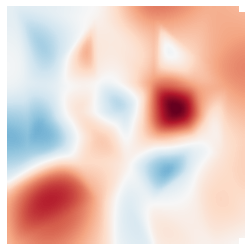

In [ ]:
# %%timeit -r 5
n_centers_min = 1
n_centers_max = 5
neighbourhoods_min = 2
neighbourhoods_max = 5

threads = 5
samples = 20

generate_sample_eeg_data(n_centers_min, n_centers_max, samples, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed)

Sample 0 with 5 centers before adding noise


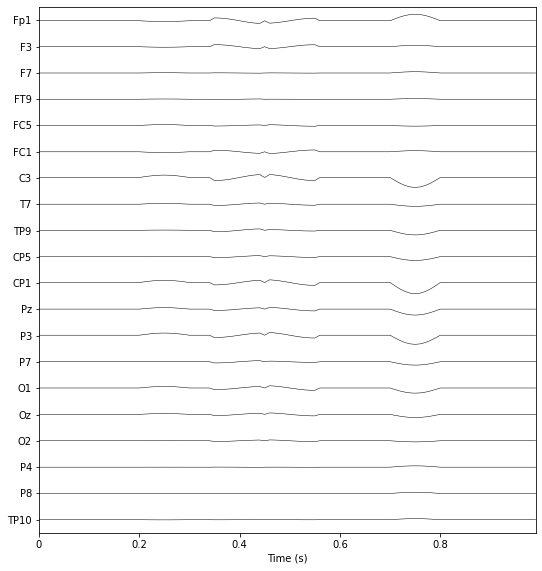

new peak with activation 2.2216397049548396e-06 found at t=21
new peak with activation 4.225809836514684e-06 found at t=22
new peak with activation 5.816328258328062e-06 found at t=23
new peak with activation 6.837503945474402e-06 found at t=24
new peak with activation 7.189377106746441e-06 found at t=25
new peak with activation 8.114336187454588e-06 found at t=46


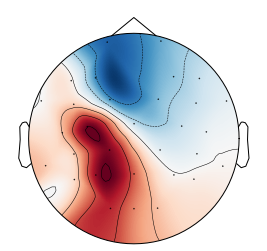

before[[ 1.96938846e-06  2.95883167e-06  1.90338053e-06  3.86116733e-07
 -1.78182674e-07  1.37406240e-06  2.26708974e-06 -4.32124114e-07
  2.15508102e-06  7.44971682e-07  8.31098792e-07  8.10554291e-07
  9.37974615e-07  3.04402922e-06  3.65701579e-07 -6.62292700e-07
  1.02089827e-06 -3.92228319e-08 -1.34599340e-06  1.55187373e-06
  6.99086709e-07  3.17197557e-06 -1.18625282e-07  1.84886959e-06
  2.55641281e-06  1.46867238e-06 -3.24260174e-06 -5.24002876e-06
  1.44174963e-06  6.68821948e-07  6.35655087e-07], 62] after[[ 1.96938846e-06  2.95883167e-06  1.90338053e-06  3.86116733e-07
 -1.78182674e-07  1.37406240e-06  2.26708974e-06 -4.32124114e-07
  2.15508102e-06  7.44971682e-07  8.31098792e-07  8.10554291e-07
  9.37974615e-07  3.04402922e-06  3.65701579e-07 -6.62292700e-07
  1.02089827e-06 -3.92228319e-08 -1.34599340e-06  1.55187373e-06
  6.99086709e-07  3.17197557e-06 -1.18625282e-07  1.84886959e-06
  2.55641281e-06  1.46867238e-06 -3.24260174e-06 -5.24002876e-06
  1.44174963e-06  6.68

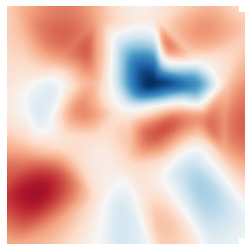

Sample 0 with 5 centers after adding noise


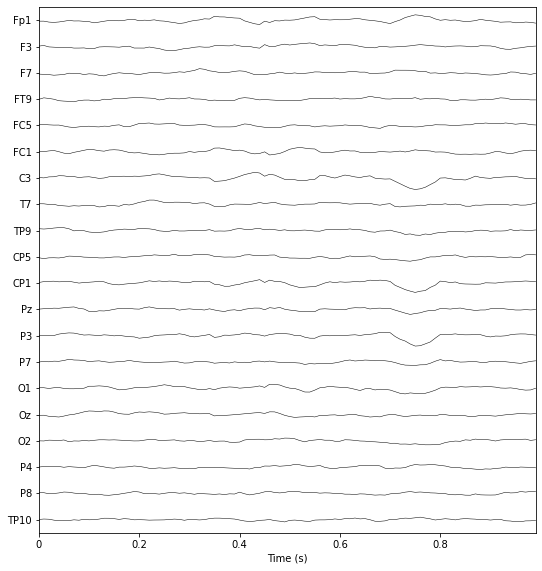

0 finished
Sample 1 with 1 centers before adding noise


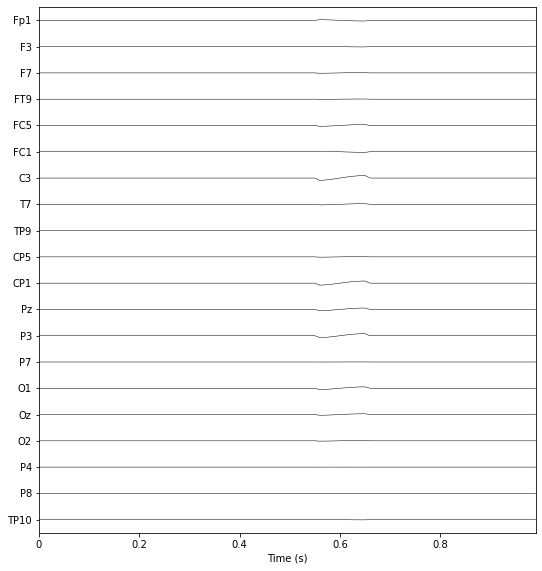

new peak with activation 2.199844935125509e-06 found at t=61
new peak with activation 4.184353720780035e-06 found at t=62
new peak with activation 5.759268810137937e-06 found at t=63
new peak with activation 6.7704265411741915e-06 found at t=64
new peak with activation 7.118847750024814e-06 found at t=65


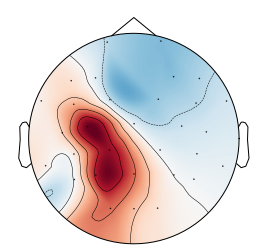

before[[ 5.31553696e-07  2.16442106e-06  1.66896893e-06  1.80830702e-06
  1.31449096e-06 -1.30605499e-06  2.26512980e-06 -9.83584161e-08
  3.29100130e-06  2.59132605e-06  3.65044768e-06 -6.68426867e-07
 -2.20351848e-06 -5.77259960e-07  6.29343082e-07 -1.70990610e-06
 -7.77607738e-07  2.08975916e-06 -1.52054232e-06  4.49245176e-06
  2.06881323e-06 -1.41453071e-07 -9.99454983e-08  1.65886203e-06
  3.30098187e-06  4.37544702e-08 -1.23476702e-06  1.39485941e-06
 -5.06193393e-07  2.90538185e-06  9.84628636e-07], 24] after[[ 5.31553696e-07  2.16442106e-06  1.66896893e-06  1.80830702e-06
  1.31449096e-06 -1.30605499e-06  2.26512980e-06 -9.83584161e-08
  3.29100130e-06  2.59132605e-06  3.65044768e-06 -6.68426867e-07
 -2.20351848e-06 -5.77259960e-07  6.29343082e-07 -1.70990610e-06
 -7.77607738e-07  2.08975916e-06 -1.52054232e-06  4.49245176e-06
  2.06881323e-06 -1.41453071e-07 -9.99454983e-08  1.65886203e-06
  3.30098187e-06  4.37544702e-08 -1.23476702e-06  1.39485941e-06
 -5.06193393e-07  2.90

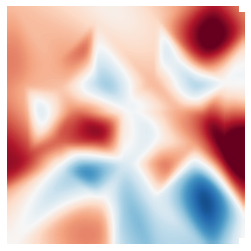

Sample 1 with 1 centers after adding noise


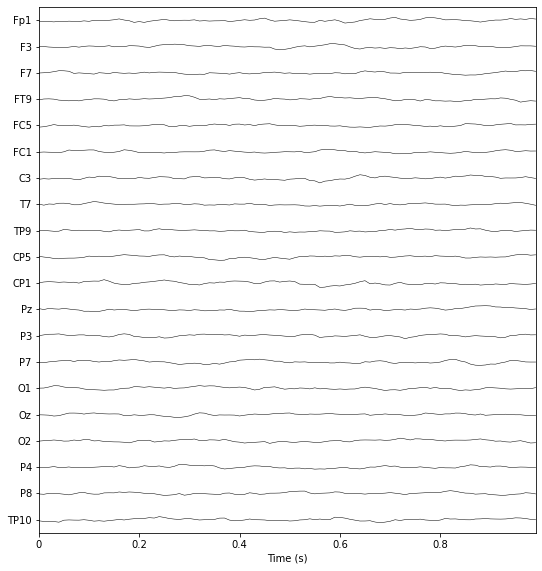

Sample 2 with 5 centers before adding noise


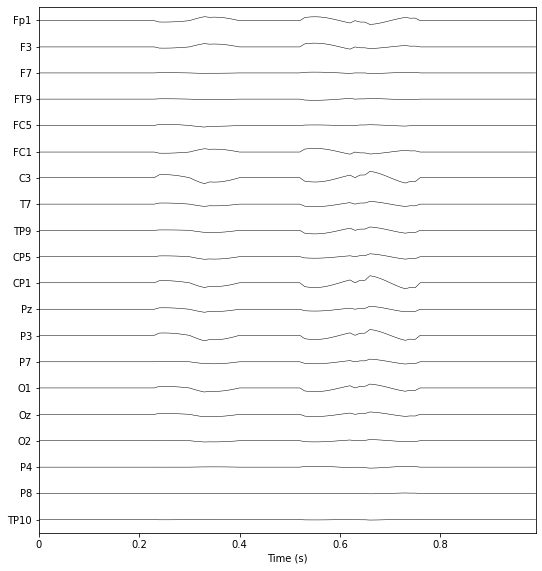

new peak with activation 7.376978429379863e-06 found at t=24
new peak with activation 7.75661414751347e-06 found at t=25
new peak with activation 9.785224641778302e-06 found at t=66


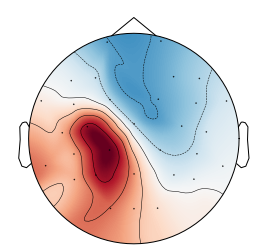

before[[ 5.06735924e-06  3.89082511e-06  2.09272514e-06 -7.11099870e-07
 -1.17300155e-06  2.13951148e-06 -5.25708992e-06 -5.39196695e-07
 -1.52504344e-06 -1.51333999e-06 -4.84387710e-06 -1.23538754e-06
 -3.82109012e-06 -9.81074234e-07 -1.46258015e-06  7.33420087e-07
  3.83128607e-06  9.04526084e-07  3.74529952e-06  4.95731097e-07
 -5.76057075e-07  1.70566124e-06  2.88118777e-06  2.23162968e-06
  2.84993023e-07  2.35353716e-07  4.22551872e-06  2.18834341e-06
  3.09722337e-06  3.96105726e-06  4.28992615e-06], 72] after[[ 5.06735924e-06  3.89082511e-06  2.09272514e-06 -7.11099870e-07
 -1.17300155e-06  2.13951148e-06 -5.25708992e-06 -5.39196695e-07
 -1.52504344e-06 -1.51333999e-06 -4.84387710e-06 -1.23538754e-06
 -3.82109012e-06 -9.81074234e-07 -1.46258015e-06  7.33420087e-07
  3.83128607e-06  9.04526084e-07  3.74529952e-06  4.95731097e-07
 -5.76057075e-07  1.70566124e-06  2.88118777e-06  2.23162968e-06
  2.84993023e-07  2.35353716e-07  4.22551872e-06  2.18834341e-06
  3.09722337e-06  3.96

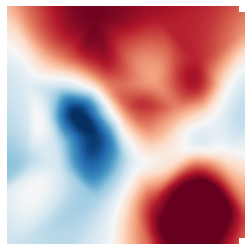

Sample 2 with 5 centers after adding noise


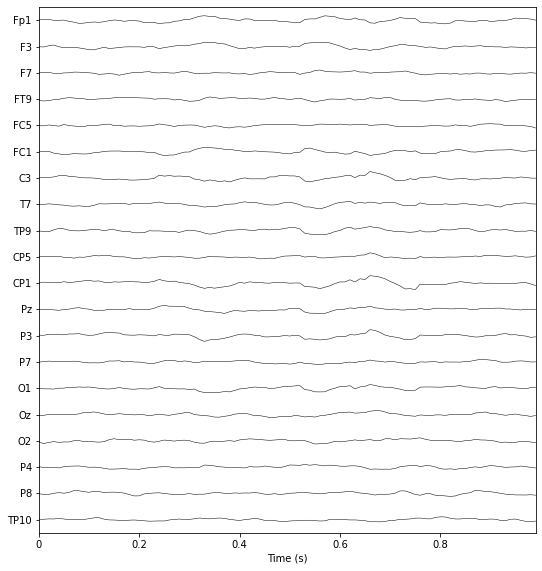

Sample 3 with 4 centers before adding noise


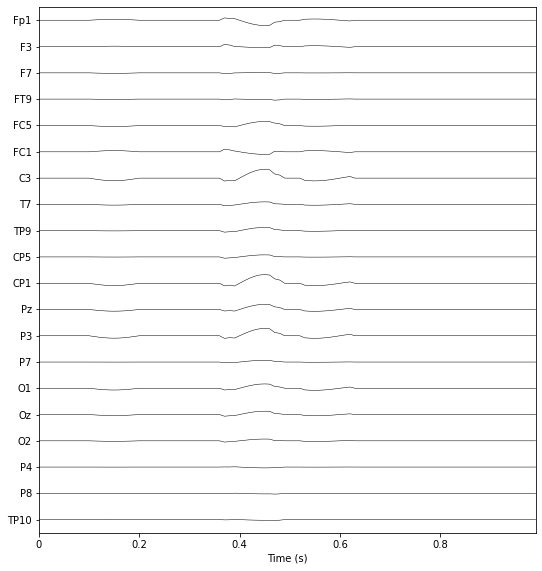

new peak with activation 9.136457241900205e-22 found at t=10
new peak with activation 5.0964677249078165e-06 found at t=41
new peak with activation 9.694057679722983e-06 found at t=42
new peak with activation 1.3342725726375457e-05 found at t=43
new peak with activation 1.568531481469373e-05 found at t=44
new peak with activation 1.6492516002935314e-05 found at t=45


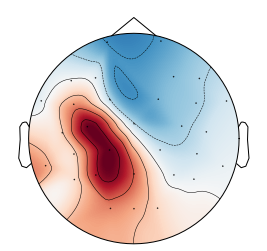

before[[ 1.38530986e-06  5.71991188e-07  1.80964908e-06 -7.46980788e-07
 -4.85567781e-07  3.92825207e-07  3.07357271e-07 -8.62600492e-07
  5.76297083e-07  5.41893094e-06  1.70319393e-06  5.04423229e-07
  3.71702830e-06  3.69469304e-06 -1.19929436e-07 -2.63227957e-06
 -6.89723882e-07  3.22783940e-06  5.09900861e-07 -2.27831830e-06
 -7.76139388e-07  3.27432414e-06  2.28026882e-06  1.77095290e-06
  2.05500845e-08  7.03917857e-07 -2.84015497e-06  1.73975050e-06
  1.63167395e-06  9.66546352e-07  9.03623320e-07], 95] after[[ 1.38530986e-06  5.71991188e-07  1.80964908e-06 -7.46980788e-07
 -4.85567781e-07  3.92825207e-07  3.07357271e-07 -8.62600492e-07
  5.76297083e-07  5.41893094e-06  1.70319393e-06  5.04423229e-07
  3.71702830e-06  3.69469304e-06 -1.19929436e-07 -2.63227957e-06
 -6.89723882e-07  3.22783940e-06  5.09900861e-07 -2.27831830e-06
 -7.76139388e-07  3.27432414e-06  2.28026882e-06  1.77095290e-06
  2.05500845e-08  7.03917857e-07 -2.84015497e-06  1.73975050e-06
  1.63167395e-06  9.66

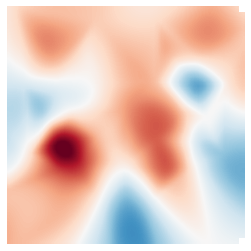

Sample 3 with 4 centers after adding noise


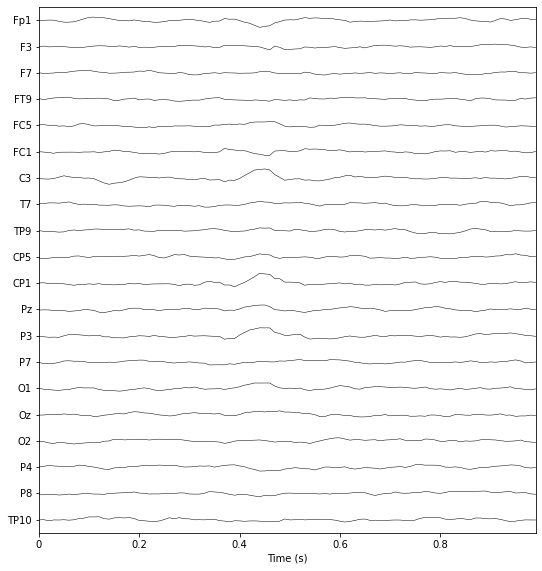

KeyboardInterrupt: 

In [ ]:
# paper values for training data
n_centers_min = 1
n_centers_max = 5
neighbourhoods_min = 2
neighbourhoods_max = 5

samples = generate_sample_eeg_data(n_centers_min, n_centers_max, 5, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, True)

# paper values for validation data
n_centers_min = 1
n_centers_max = 10
neighbourhoods_min = 2
neighbourhoods_max = 7

#alt_samples = generate_sample_eeg_data(n_centers_min, n_centers_max, 1, neighbourhoods_min, neighbourhoods_max, alt_source_spaces, alt_fwd_fixed, True)

print(np.shape(samples))
print(f'--- input image data ---')
print(np.shape(samples[0][0]))
print(samples[0][0])
print(f'--- dipole data ---')
print(np.shape(samples[0][1]))
print(samples[0][1])

0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
0 finished
23 s ± 4.49 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


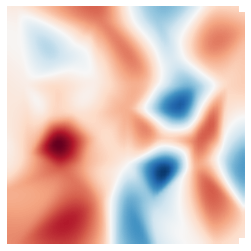

In [ ]:
%%timeit -r 10
n_centers_min = 1
n_centers_max = 5
neighbourhoods_min = 2
neighbourhoods_max = 5
samples = generate_sample_eeg_data(n_centers_min, n_centers_max, 5, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)

In [ ]:
# Ribera et al 2019, equation (7)
# assumption: alpha = - 1
def generalized_mean(p, omega, y, verbose=False):
  alpha = -1

  d_max = 0.
  for x in omega:
    if eucl_dist(x, y) > d_max:
      d_max = eucl_dist(x, y)
  
  if verbose:
    print(f'd_max: {d_max} for y={y}')
  sum = 0.
  for p_x, x in zip(p, omega):
    sum += math.pow(p_x * eucl_dist(x, y) + (1 - p_x) * d_max, alpha)
  
  sum /= len(omega)

  return math.pow(sum, 1/alpha)

# see paper by Ribera et al 2019
def weighted_hausdorff_distance(network_output, dipoles, ground_truth, verbose=False):
  ''' network_output is a vector of values between 0 and 1, dipoles is a set 
  of coordinates, ground_truth the subset of dipoles which are the activation 
  centers
  '''

  p = network_output
  omega = dipoles
  Y = ground_truth
  epsilon = 1E-6


  S = np.sum(network_output)

  if verbose:
    print(f'S: {S}')

  x_part = 0.

  if verbose:
    print('Calculating first part of equation:')
  for p_x, x in zip(p, omega):
    min_dist = -1
    if verbose:
      print(f'x={x}, p_x={p_x}')
    for y in Y: 
      if (eucl_dist(x, y) < min_dist) or min_dist == -1:
        min_dist = eucl_dist(x, y)
    if verbose: 
      print(f'p_x * min_dist: {p_x * min_dist}')
    x_part += p_x * min_dist
  
  x_part /= (S + epsilon)

  if verbose:
    print(f'result for first part of equation: {x_part}')

  y_part = 0.
  for y in Y:
    mean = generalized_mean(p, omega, y, verbose)
    y_part += mean
    if verbose:
      print(f'y={y} has generalized mean {mean}')

  y_part /= len(Y)

  if verbose:
    print(f'second part of equation: {y_part}')

  return x_part + y_part

In [ ]:
# test whd, reuse test data

dipoles = test_neighbourhood
bad_output = []
good_output = []
extremely_good_output = []
for i in range(len(dipoles)): 
  bad_output.append(0.1)
  if i == 0:
    good_output.append(0.9)
    extremely_good_output.append(0.999)
  else:
    good_output.append(0.01)
    extremely_good_output.append(0.0001)

print(f'BAD WDH: {weighted_hausdorff_distance(bad_output, dipoles, [test_center], verbose=True)}\n')

print(f'GOOD WDH: {weighted_hausdorff_distance(good_output, dipoles, [test_center], verbose=True)}\n')

print(f'EXTREMELY GOOD WDH: {weighted_hausdorff_distance(extremely_good_output, dipoles, [test_center], verbose=True)}\n')

NameError: name 'test_neighbourhood' is not defined

In [ ]:
class ConvDip(torch.nn.Module):
  def __init__(self):
    super(ConvDip, self).__init__()
    self.conv = torch.nn.Conv2d(1,8,(3,3))
    self.batch_norm_1 = torch.nn.BatchNorm2d(8)
    self.flatten = torch.nn.Flatten()
    self.hidden_dense = torch.nn.Linear(616, 512)
    self.batch_norm_2 = torch.nn.BatchNorm2d(512)
    self.output = torch.nn.Linear(512, 5124)
    self.activation = torch.nn.ReLU()
  
  def forward(self, x):
    x = self.conv(x)
    x = self.activation(x)
    x = self.batch_norm_1(x)
    x = self.flatten(x)
    x = self.hidden_dense(x)
    x = self.activation(x)
    x = self.batch_norm_2(x)
    x = self.output(x)
    x = self.activation(x)
    return x

In [ ]:
class SampledEEGDataset(torch.utils.data.Dataset):
  def __init__(self, input=None, output=None, filepath=None):
    print()
    if (input is None or output is None) and filepath is None:
      raise Exception('Input und Output müssen gegeben sein, oder ein filepath zum Laden eines Dataset Files')
    
    if input and output:
      self.input = torch.stack(input)
      self.output = torch.tensor(create_array(output))
    
    if filepath:
      self.load(filepath)

  def __len__(self):
        return len(self.input)
  
  def getitem(self, idx):
        return (self.input[idx], self.output[idx])

  def save(self, filepath):
    data = (self.input, self.output)
    torch.save(data, filepath)
  
  def load(self, filepath):
    inp, out = torch.load(filepath)
    self.input = inp
    self.output = out
    
  def concat(self, inp, out):
    self.input = torch.cat((self.input, inp), 0)
    self.output = torch.cat((self.output, out), 0)

Die nächste Zelle mit Bedacht ausführen

Exception: Input und Output müssen gegeben sein, oder ein filepath zum Laden eines Dataset Files

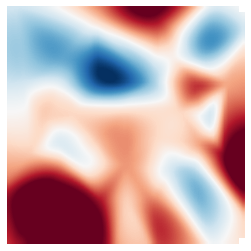

In [ ]:
#%%capture
n_centers_min = 1
n_centers_max = 5
neighbourhoods_min = 2
neighbourhoods_max = 5

train_inp, train_out = generate_sample_eeg_data(n_centers_min, n_centers_max, 1000, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)

n_centers_min = 1
n_centers_max = 10
neighbourhoods_min = 2
neighbourhoods_max = 7
val_inp, val_out = generate_sample_eeg_data(n_centers_min, n_centers_max, 200, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)

In [ ]:
save_path = "C:\\Users\\Max Ksoll\\PycharmProjects\\TestProject\\data"

train_dataset = SampledEEGDataset(input=train_inp, output=train_out)
train_dataset.save(save_path+"\\train_set.pt")
val_dataset = SampledEEGDataset(input=val_inp, output=val_out)
val_dataset.save(save_path+"\\val_set.pt")

In [ ]:
save_path = "C:\\Users\\Max Ksoll\\PycharmProjects\\TestProject\\data"
complete_time = 0.
for idx in range(100):
    
    start = int(round(process_time() * 1000))  
    
    n_centers_min = 1
    n_centers_max = 5
    neighbourhoods_min = 2
    neighbourhoods_max = 5

    train_inp, train_out = generate_sample_eeg_data(n_centers_min, n_centers_max, 1000, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)

    n_centers_min = 1
    n_centers_max = 10
    neighbourhoods_min = 2
    neighbourhoods_max = 7
    val_inp, val_out = generate_sample_eeg_data(n_centers_min, n_centers_max, 200, neighbourhoods_min, neighbourhoods_max, source_spaces, fwd_fixed, False)
    
    train_dataset.concat(torch.stack(train_inp), torch.tensor(create_array(train_out)))
    val_dataset.concat(torch.stack(val_inp), torch.tensor(create_array(val_out)))
    train_dataset.save(save_path+"\\train_set.pt")
    val_dataset.save(save_path+"\\val_set.pt")
          
    end_ = int(round(process_time())) - start
    complete_time += end_
    
    print(f"Total execution time for 1200 Examples: {end_ if end_ > 0 else 0} s")
    
    if not idx % 10:
        print("Average Execution Time {}s".format(complete_time/(idx+1)))

In [ ]:
BATCH_SIZE = 100
EPOCHS = 10
MODEL = ConvDip()
OPTIMIZER = torch.optim.Adam(MODEL.parameter())
LOSS_FN = torch.nn.MSELoss()

In [ ]:
train_set = torch.utils.data.Dataloader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=-1)
val_set = torch.utils.data.Dataloader(dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=-1)

In [ ]:
class TrainWrapper():
  def __init__(self, model, train_set, test_set, val_set, optimizer, loss_fn, epochs, print_after_every_x_minibatch=1000):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(self.device)
    self.model = model
    self.train_set = train_set
    self.test_set = test_set
    self.val_set = val_set
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.epochs = epochs
    self.print_after_every_x_minibatch = print_after_every_x_minibatch
  
  def fit(self, verbose=False):
    for epoch in range(self.epochs):
      self.train_step(epoch+1, verbose=verbose)
      if verbose:
        print(f'[{epoch}] Val-loss: {val_step():.4f}')

  def train_step(self, epoch, verbose=False):
    running_loss = 0.0
    for i, data in enumerate(self.train_set, 0):
        inputs, labels = data
        inputs = inputs.to(self.device)
        labels = inputs.to(self.device)
        self.optimizer.zero_grad()

        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()

        running_loss += loss.item()
        if i % self.print_after_every_x_minibatch == self.print_after_every_x_minibatch-1:    # print every 2000 mini-batches
            print(f'[{epoch}, {i}] loss: {running_loss / self.print_after_every_x_minibatch:.4f}')
            running_loss = 0.0

  def val_step(self, validation=True):
    if validation:
      dataset = self.val_set
    else:
      dataset = self.test_set

    running_loss = 0.0
    for i, data in enumerate(dataset, 0):
        inputs, labels = data

        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()

        running_loss += loss.item()
    return running_loss/(i+1)

In [ ]:
model = TrainWrapper(MODEL, train_set, None, val_set, OPTIMIZER, LOSS_FN, EPOCHS)
model.fit()

## TODO: 
- alternative GM (electrode pos verschieben), 
- echtes noise verwenden
- transformation from alternative source space (\~8k dipoles) into training source space (\~5k dipoles),
- visualisierungen mit PyCharm
- (prio) training infrastructure
- (prio) training durchführen
- rescale network output (brent's method, see paper section 2.3)
- validation
- anderes netzwerk
- (prio) aufräumen und dokumentation

## erledigt:
- (prio) select time point with "signal peak", 
- (prio) transform channel data into 7x11 image, 
- (prio) implement ConvDip,
- (prio) implement weighted Hausdorff distance
- 

## Antworten Konsultation

- conductivity: genaue Werte sind egal, hauptsache es kommt was sinnvolles raus
(man kann auch mit versch Werten experimentieren, um zu sehen, was sich ändert)
- visualisierungen in PyCharm machen, nicht in Colab
- neighbourhoods: n nächste Nachbarn bilden eine Neighbourhood order (n können
wir selbst wählen, z.B. 5 oder 7), hat keine Prio, wir können auch mit single 
activations arbeiten
- noise: kein noise verwenden ist ok, standard-noise auch, am besten: echtes noise
- attenuation: das die werte niedrig sind, ist normal, skalierung kann man beim
plot einstellen
